# **Systèmes de Recherche d'Images par le Contenu - Approche Deep"**

La recherche d'images basée sur le contenu consiste à retrouver dans une base de données les images visuellement similaires à une image donnée, en se basant sur leurs caractéristiques visuelles.
Avec l’essor de l’apprentissage profond, les méthodes CBIR ont considérablement évolué. Les réseaux neuronaux permettent désormais d’extraire des descripteurs riches et discriminants, capturant à la fois des détails locaux et des informations sémantiques globales.

Dans ce projet, nous allons comparer deux approches principales pour l’extraction de features en CBIR :

1. **Réseau CNN pré-entraîné** (VGG16, ResNet50, etc) :  
   - Utilisé comme extracteur de caractéristiques.  
   - Les couches profondes fournissent des représentations hiérarchiques des images (bords, textures) à des concepts plus complexes.  

2. **Autoencodeur profond** :  
   - Apprend à encoder une image dans un code latent compact puis à la reconstruire.  
   - Le code latent est utilisé comme vecteur de descripteur
  
  **Objectifs du TP :**  

- Charger et prétraiter la base d’images fournie
- Utiliser un CNN pré-entraîné pour extraire des descripteurs  
- Construire et entraîner un autoencodeur profond
- Définir une métrique de similarité (cosine ou euclidienne)  
- Effectuer des recherches CBIR et afficher les images les plus similaires à une image requête  
- Visualiser les feature maps pour comprendre les représentations apprises par chaque type de réseau  



# **2. Importer les librairies nécessaires**

In [50]:
import numpy as np
from pathlib import Path
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import torchvision.models as models
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

import torch.nn as nn   

import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# **3. Chargement et prétraitement des images**

La base Corel contient 100 images divisées en 10 classes. La base est déjà divisée en train et test. Les images doivent être prétraitées selon le modèle utilisé.

Afficher quelques images aléatoires pour vérifier que le chargement est correct.

In [51]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        # general normalization that works well for most images
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        
    )
])

train_dataset = datasets.ImageFolder(r"C:\Users\LOQ\code\image-indexing-and-watermarking\DeepCIBR\DeepCBIR_Dataset\training_set", transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)

test_dataset = datasets.ImageFolder(r"C:\Users\LOQ\code\image-indexing-and-watermarking\DeepCIBR\DeepCBIR_Dataset\test_set", transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2739873].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4134207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2317834].


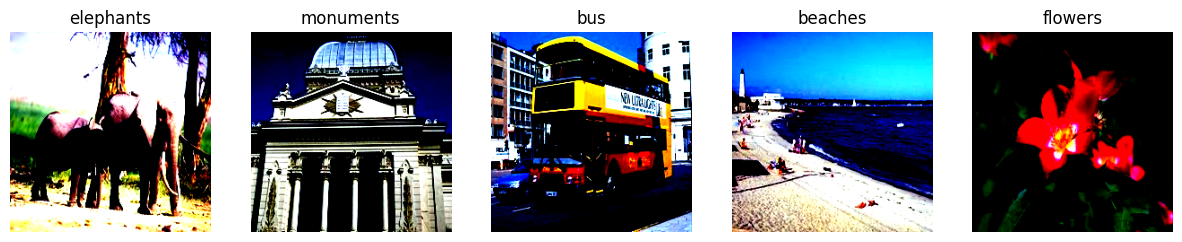

In [52]:
def show_random_images(dataset, class_names=None, num_images=5):
    plt.figure(figsize=(15,3))
    for i in range(num_images):
        idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[idx]
        img = img.permute(1, 2, 0)  # Change shape for plt.imshow
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        if class_names:
            plt.title(class_names[label])
        else:
            plt.title(f"Label: {label}")
    plt.show()
    
show_random_images(train_dataset, class_names=train_dataset.classes, num_images=5)

# **4. CNN Pré-entraîné sur la base ImageNet**
# Construction du Feature Extractor

Utiliser un CNN pré-entraîné comme extracteur de features, charger le modèle (VGG16, ResNet50..) avec `weights='imagenet'`, retirer la couche de classification (include_top=False). Le modèle doit être non entraînable(`trainable=False`)

# Extraction des descripteurs CNN
Générer pour chaque image un vecteur de caractéristiques

# Visualisation des Feature Maps
Comparer feature maps de différentes couches pour comprendre la hiérarchie des
représentations.

In [53]:
vgg_model = models.vgg16(weights='IMAGENET1K_V1').eval() 


# Créer l'extracteur avec les couches désirées
return_nodes = {
    'features.0':  'conv_early',   # premières convolutions (bords, textures)
    'features.15': 'conv_mid',     # profondeur intermédiaire
    'features.28': 'conv_deep',    # plus haut niveau
}

print(get_graph_node_names(vgg_model))

feature_extractor = create_feature_extractor(vgg_model, return_nodes=return_nodes)

feature_extractor.to(device)
feature_extractor.eval()

for param in feature_extractor.parameters():
    param.requires_grad = False


img, _ = train_dataset[2]

# Utilisation (retourne un dictionnaire)
with torch.no_grad():
    # to(device) pour utiliser le GPU si disponible
    img = img.to(device)
    features = feature_extractor(img.unsqueeze(0))
    ''' feats est un dict :
    # feats['conv_early'] : (1, C1, H1, W1)
    # feats['conv_mid']   : (1, C2, H2, W2)
    # feats['conv_deep']  : (1, C3, H3, W3) '''


(['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'features.21', 'features.22', 'features.23', 'features.24', 'features.25', 'features.26', 'features.27', 'features.28', 'features.29', 'features.30', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6'], ['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'features.21', 'features.22', 'features.23', 'features.24', 'features.25', 'features.26', 'f

In [54]:
def show_feature_maps_from_layer(feats_dict, layer_key, num_maps=6):
    maps = feats_dict[layer_key][0]     # (C, H, W), on enlève le batch
    C = maps.shape[0]
    num_maps = min(num_maps, C)

    plt.figure(figsize=(3 * num_maps, 3))
    for i in range(num_maps):
        plt.subplot(1, num_maps, i + 1)
        plt.imshow(maps[i].cpu(), cmap='viridis')
        plt.axis('off')
    plt.suptitle(f'Feature maps - {layer_key}')
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


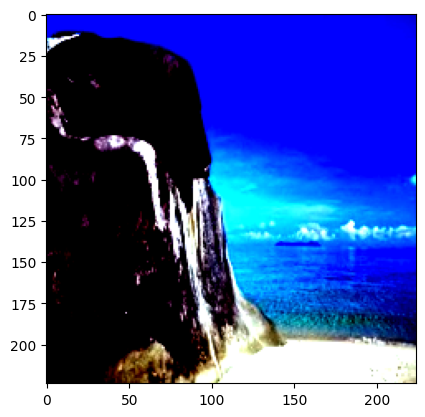

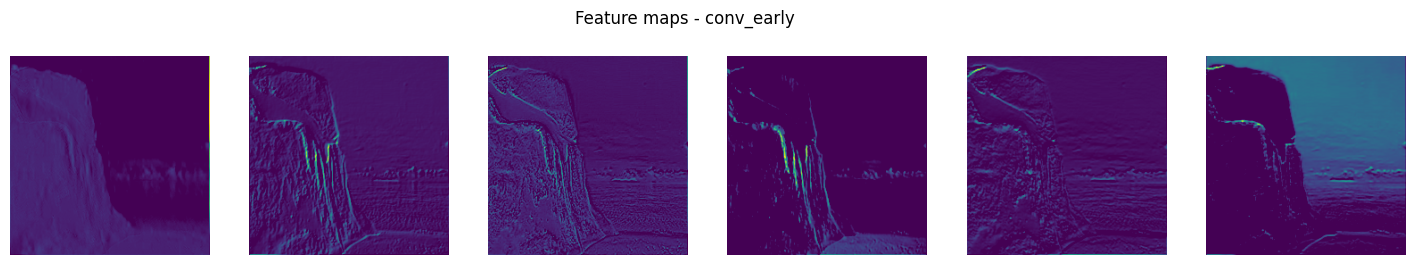

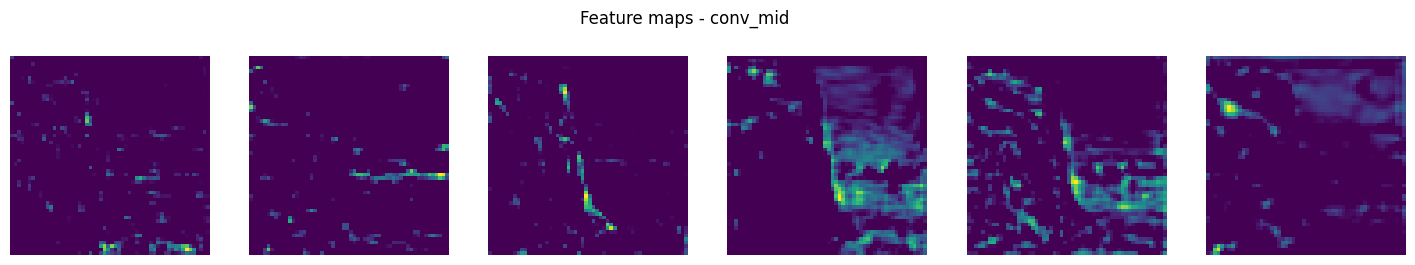

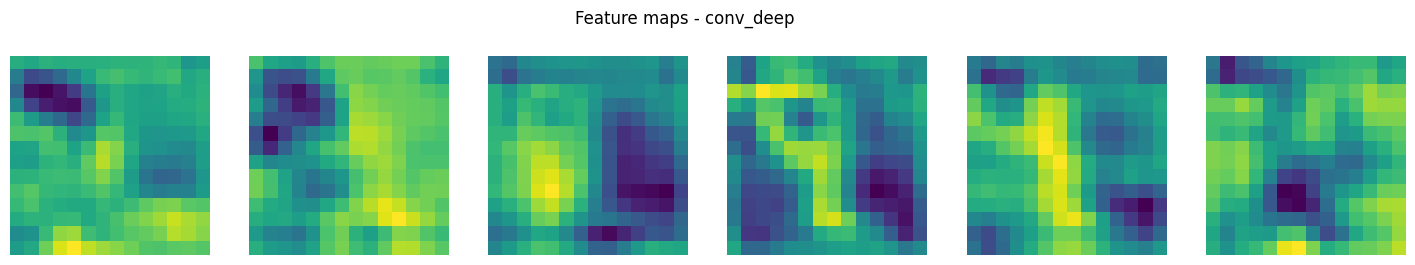

In [55]:
plt.imshow(img.cpu().permute(1, 2, 0))  # afficher l'image originale
show_feature_maps_from_layer(features, 'conv_early', num_maps=6)  # bords, textures
show_feature_maps_from_layer(features, 'conv_mid',   num_maps=6)  # motifs plus complexes
show_feature_maps_from_layer(features, 'conv_deep',  num_maps=6)  # parties / objets


* Première feature map : détecte des motifs très simples comme les bords, orientations et contrastes locaux (horizontal, vertical, coins), donc l’activation suit encore assez bien la structure « brute » de l’image.

* Feature map intermédiaire : combine plusieurs motifs bas niveau pour repérer des textures et formes plus complexes (motifs répétitifs, parties d’objets), avec une résolution spatiale déjà réduite et plus d’invariance aux petits déplacements.

* Dernière feature map : chaque canal code la présence de concepts très abstraits (parties d’objets ou quasi‑classes), sur une petite grille spatiale (par ex. 7×7), donc on vois des “pixels”, mais ce sont des scores d’activation très condensés qui résument l’image entière.

In [56]:
def extract_descriptors(dataloader, model, device, couche='conv_deep'):
    all_descriptors = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            out = model(imgs)
            # Utiliser les features de la couche 'conv_deep'
            feat_maps = out['conv_deep']  # (B, C, H, W)
            vecs = feat_maps.mean(dim=(2, 3))  # (B, C)

            all_descriptors.append(vecs.cpu())
            all_labels.append(labels)

    all_descriptors = torch.cat(all_descriptors, dim=0)  # (N, C)
    all_labels = torch.cat(all_labels, dim=0)            # (N,)

    return all_descriptors, all_labels

In [57]:
# all_descriptors, _ = extract_descriptors(train_dataloader, feature_extractor, device)

# print(all_descriptors.shape)  # N x dim_feature

# **5. Autoencodeur profond**

# Build Autoencoder
- Encoder : plusieurs couches Conv2D + MaxPooling2D + Flatten + Dense(code_size)

- Decoder : Dense + Reshape + Conv2DTranspose pour reconstruire l'image

- Le modèle final prend une image en entrée et la reconstruit

In [58]:
class Encoder(nn.Module):
    def __init__(self, code_size=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),    # (B,64,224,224)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                  # (B,64,112,112)

            nn.Conv2d(64, 128, 3, padding=1), # (B,128,112,112)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),                  # (B,128,56,56)

            nn.Conv2d(128, 256, 3, padding=1),# (B,256,56,56)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),                  # (B,256,28,28)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256 * 28 * 28, code_size)  # 200704 → code_size

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        code = self.fc(x)
        return code

In [59]:
class Decoder(nn.Module):
    def __init__(self, code_size=128):
        super().__init__()
        self.fc = nn.Linear(code_size, 256 * 28 * 28)

        self.deconv = nn.Sequential(
            # (B,256,28,28) -> (B,128,56,56)
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # (B,128,56,56) -> (B,64,112,112)
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # (B,64,112,112) -> (B,3,224,224)
            nn.ConvTranspose2d(64, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()   # si tes images sont en [0,1]
        )

    def forward(self, code):
        x = self.fc(code)                     # (B, 256*28*28)
        x = x.view(-1, 256, 28, 28)          # (B,256,28,28)
        x = self.deconv(x)                   # (B,3,224,224)
        return x


In [60]:
class Autoencoder(nn.Module):
    def __init__(self, code_size=128):
        super().__init__()
        self.encoder = Encoder(code_size)
        self.decoder = Decoder(code_size)

    def forward(self, x):
        code = self.encoder(x)
        recon = self.decoder(code)
        return recon, code


# Extraction des descripteurs

In [61]:
def extract_encoder_descriptors(dataloader, encoder, device):
    encoder.eval()
    all_codes = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)          # (B, 3, H, W)
            codes = encoder(imgs)           # (B, code_size)
            all_codes.append(codes.cpu())
            all_labels.append(labels)

    all_codes = torch.cat(all_codes, dim=0)    # (N, code_size)
    all_labels = torch.cat(all_labels, dim=0)  # (N,)
    return all_codes, all_labels

In [62]:
encoder = Encoder(code_size=128).to(device)
decoder = Decoder(code_size=128).to(device)

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim

autoencoder = Autoencoder(code_size=128).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

num_epochs = 100

for epoch in range(num_epochs):
    autoencoder.train()
    running_loss = 0.0

    for imgs, _ in train_dataloader:  
        imgs = imgs.to(device)

        optimizer.zero_grad()
        recon, codes = autoencoder(imgs)
        loss = criterion(recon, imgs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(train_dataloader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - loss: {epoch_loss:.4f}")


Epoch 1/100 - loss: 1.6796
Epoch 2/100 - loss: 1.4797
Epoch 3/100 - loss: 1.3861
Epoch 4/100 - loss: 1.3221
Epoch 5/100 - loss: 1.2888
Epoch 6/100 - loss: 1.2687
Epoch 7/100 - loss: 1.2546
Epoch 8/100 - loss: 1.2378
Epoch 9/100 - loss: 1.2302
Epoch 10/100 - loss: 1.2175
Epoch 11/100 - loss: 1.2116
Epoch 12/100 - loss: 1.2042
Epoch 13/100 - loss: 1.1949
Epoch 14/100 - loss: 1.1933
Epoch 15/100 - loss: 1.1842
Epoch 16/100 - loss: 1.1778
Epoch 17/100 - loss: 1.1737
Epoch 18/100 - loss: 1.1693
Epoch 19/100 - loss: 1.1657
Epoch 20/100 - loss: 1.1611
Epoch 21/100 - loss: 1.1543
Epoch 22/100 - loss: 1.1560
Epoch 23/100 - loss: 1.1508
Epoch 24/100 - loss: 1.1485
Epoch 25/100 - loss: 1.1426
Epoch 26/100 - loss: 1.1357
Epoch 27/100 - loss: 1.1347
Epoch 28/100 - loss: 1.1426
Epoch 29/100 - loss: 1.1347
Epoch 30/100 - loss: 1.1233
Epoch 31/100 - loss: 1.1212
Epoch 32/100 - loss: 1.1339
Epoch 33/100 - loss: 1.1256
Epoch 34/100 - loss: 1.1186
Epoch 35/100 - loss: 1.1134
Epoch 36/100 - loss: 1.1097
E

# Visualisation du vecteur latent de l’autoencodeur
- Comprendre ce que l'encodeur a appris pour représenter l'image

- Afficher le vecteur code latent produit par l'encodeur

- Comparer avec l'image reconstruite par le decoder

In [ ]:
def show_pair(orig, rec):
    orig = orig.permute(1, 2, 0).detach().cpu().numpy()
    rec  = rec.permute(1, 2, 0).detach().cpu().numpy()
    fig, axs = plt.subplots(1, 2, figsize=(4, 2))
    axs[0].imshow(orig); axs[0].axis('off'); axs[0].set_title("Original")
    axs[1].imshow(rec);  axs[1].axis('off'); axs[1].set_title("Reconstruit")
    plt.show()

In [72]:
autoencoder.eval()
imgs, _ = next(iter(train_dataloader))
imgs = imgs.to(device)

with torch.no_grad():
    code_orig = autoencoder.encoder(imgs)
    recon = autoencoder.decoder(code_orig)
    code_recon = autoencoder.encoder(recon)
    
code_orig = code_orig[0].cpu()
code_recon = code_recon[0].cpu()

print(f"Code original shape: {code_orig.shape}")
print(f"Code reconstruction shape: {code_recon.shape}")

Code original shape: torch.Size([128])
Code reconstruction shape: torch.Size([128])


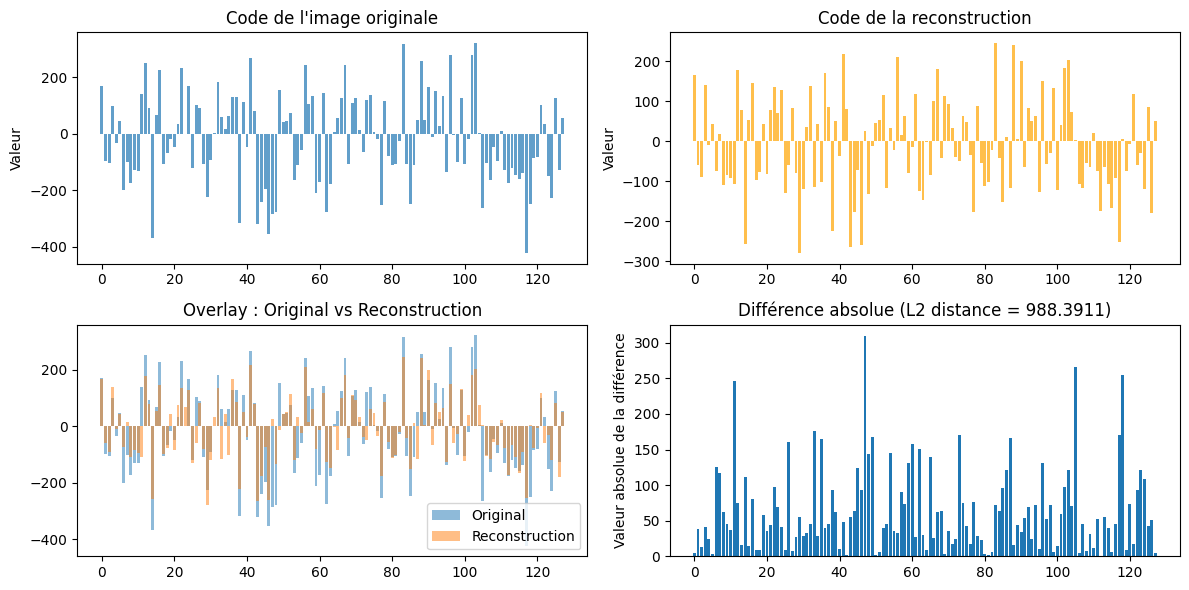

In [73]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Codes side-by-side
axes[0, 0].bar(range(len(code_orig)), code_orig.numpy(), alpha=0.7, label="Original")
axes[0, 0].set_title("Code de l'image originale")
axes[0, 0].set_ylabel("Valeur")

axes[0, 1].bar(range(len(code_recon)), code_recon.numpy(), alpha=0.7, label="Reconstruction", color='orange')
axes[0, 1].set_title("Code de la reconstruction")
axes[0, 1].set_ylabel("Valeur")

# Différence (overlay)
axes[1, 0].bar(range(len(code_orig)), code_orig.numpy(), alpha=0.5, label="Original")
axes[1, 0].bar(range(len(code_recon)), code_recon.numpy(), alpha=0.5, label="Reconstruction")
axes[1, 0].set_title("Overlay : Original vs Reconstruction")
axes[1, 0].legend()

# Distance entre les deux codes
distance = torch.norm(code_orig - code_recon).item()
diff = (code_orig - code_recon).abs()
axes[1, 1].bar(range(len(diff)), diff.numpy())
axes[1, 1].set_title(f"Différence absolue (L2 distance = {distance:.4f})")
axes[1, 1].set_ylabel("Valeur absolue de la différence")

plt.tight_layout()
plt.show()


In [74]:
# Distance L2 (euclidienne)
l2_distance = torch.norm(code_orig - code_recon).item()

# Distance cosinus
import torch.nn.functional as F
cosine_sim = F.cosine_similarity(code_orig.unsqueeze(0), code_recon.unsqueeze(0)).item()

print(f"L2 distance: {l2_distance:.6f}")
print(f"Cosine similarity: {cosine_sim:.6f}")  # proche de 1.0 = très similaire


L2 distance: 988.391052
Cosine similarity: 0.848450


### des résultats mauvais à cause de la faible capacité de l'autoencodeur

# Utiliser le VGG préentrainé comme encodeur

# **Recherche d’images similaires**

 - Comprendre comment utiliser les vecteurs descripteurs  pour rechercher des images proches dans une base.

- Comparer les performances de l’autoencodeur et du CNN pré-entraîné. Choisir la fonction distance ou similarité (cosine, distance euclidienne)

- Visualiser les résultats pour une image requête.